In [2]:
from math import sin, cos, pi, sqrt, e, log, isclose, exp
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm, pyplot as plt

import h5py
from scipy.constants import epsilon_0, mu_0
import scipy.constants

TODO: Verify that k is of the right units in every other location

First, what is the threshold excitation that Yang found? It's eq.11, 

$$P_{stress} = 0.141 \text{MPa} = \frac{2 k A}{0.58 \pi r^2}$$

$$ A = \frac{29 P \pi r^2}{100 k} $$



In [6]:
P = 141000

r = 50.0e-9
k = 70.30 # from Yang
A_threshold = (29.0 * P * r**2.0) / (100 * k)

A_threshold

1.454125177809388e-12

We want to know: using the formalism in \cite{Detection2003}, 
    
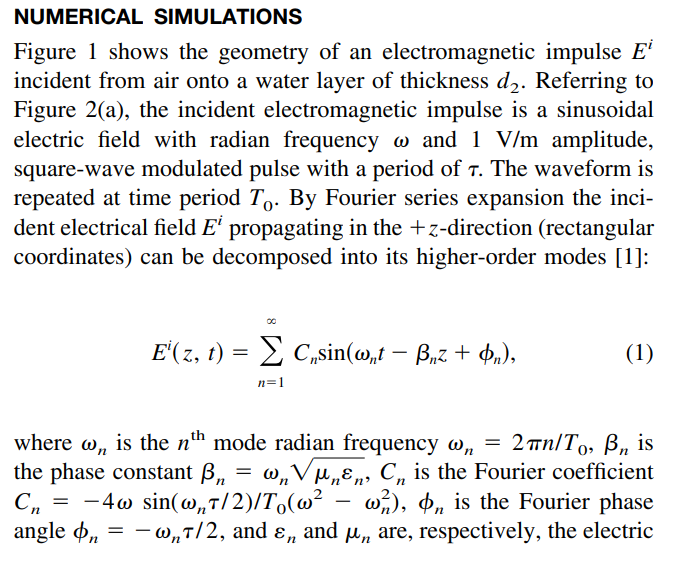


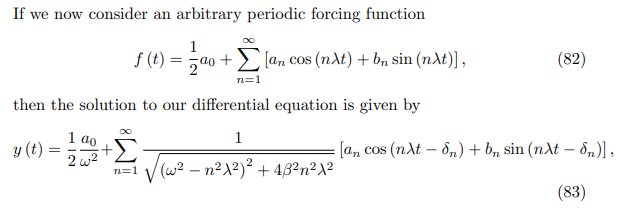



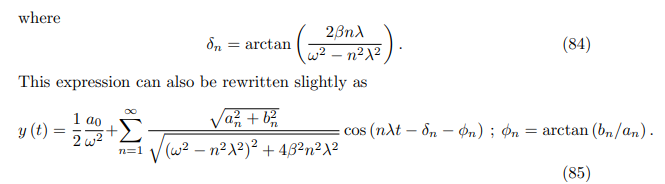

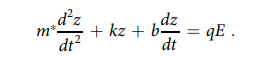

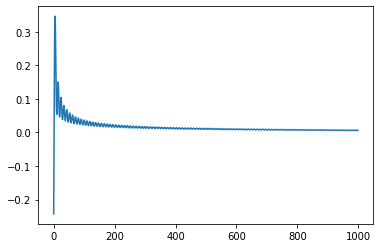

In [109]:
N = 10000
# sp = 0.01e9
# f = np.array([5e9, 10e9])

f = np.array(np.linspace(1e9, 100e9, N))
# phase = np.array([pi]*(N//2) + [0]*(N//2))

dispersion = 10/1e9

penetration_depth = 0.0046

k_tissue = 2 * pi * f * np.sqrt(epsilon_0 * f * dispersion * mu_0)


x = np.linspace(0, 0.01, 1000)

dist = 0.005

E = (np.sin(k_tissue[0] * x - dist*k_tissue[0]))
for i in range(1, len(f)):
    E += (np.sin(k_tissue[i] * x - dist*k_tissue[0]))

E /= np.linalg.norm(E)

Em = E * np.exp(-x/penetration_depth)

plt.plot(E)
# plt.plot(Em)

